#1.Imports

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505173 sha256=764dc84ab619b654bab723b2952bf17faaff763fd2b76778b45a1b6f780786b7
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.9 MB/s eta 0:00:00


In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import jaccard_score
import datetime
from surprise import Dataset, Reader, SVD
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import product
import heapq
from datasketch import MinHash, MinHashLSH
from random import randrange, uniform
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split as surprise_train_test_split


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#2.See data and make the dataset

##2.1 Lastfm dataset

In [7]:
lastfm_df = pd.read_csv('Last.fm_data.csv')
lastfm_df.head()

Unnamed: 0 Username           Artist                          Track  \
0           0  Babs_05  Isobel Campbell     The Circus Is Leaving Town   
1           1  Babs_05  Isobel Campbell                   Dusty Wreath   
2           2  Babs_05  Isobel Campbell     Honey Child What Can I Do?   
3           3  Babs_05  Isobel Campbell  It's Hard To Kill A Bad Thing   
4           4  Babs_05  Isobel Campbell                Saturday's Gone   

                       Album         Date    Time  
0  Ballad of the Broken Seas  31 Jan 2021   23:36  
1  Ballad of the Broken Seas  31 Jan 2021   23:32  
2  Ballad of the Broken Seas  31 Jan 2021   23:28  
3  Ballad of the Broken Seas  31 Jan 2021   23:25  
4  Ballad of the Broken Seas  31 Jan 2021   23:21

In [8]:
lastfm_df.drop(['Unnamed: 0'], inplace=True, axis=1)


In [9]:
# Standardize track name and artist columns
lastfm_df['Track'] = lastfm_df['Track'].str.lower().str.strip()
lastfm_df['Artist'] = lastfm_df['Artist'].str.lower().str.strip()

In [10]:
#make lower case the columns names
lastfm_df.columns=lastfm_df.columns.str.lower()

##2.2 Spotify Dataset

In [11]:
spotify_df = pd.read_csv('dataset.csv')
spotify_df.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

In [12]:
lastfm_df.columns

Index(['username', 'artist', 'track', 'album', 'date', 'time'], dtype='object')

In [13]:
spotify_df.drop(['Unnamed: 0'], inplace=True, axis=1)
(spotify_df.head())

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

In [14]:
spotify_df['track_name'] = spotify_df['track_name'].str.lower().str.strip()
spotify_df['artists'] = spotify_df['artists'].str.lower().str.strip()

##2.3 See if the datasets have common tracks to merge them

In [15]:
#find common tracks on both dataset and print also the artists on common tracks


common_tracks = set(lastfm_df['track']).intersection(set(spotify_df['track_name']))
if common_tracks:
    print(f"Common tracks: {common_tracks}")
else:
    print("No common tracks found.")

print(len(common_tracks))




Common tracks: {'juicy', 'the phoenix', 'i get along without you very well (except sometimes) - vocal version', 'kids in the dark', 'aquarium', 'famous last words', 'i want to hold your hand - remastered 2015', 'fight for you', "don't leave me", "your cheatin' heart", 'infra-red', 'never too far', 'hallucinogenics', 'welcome to the jungle', 'i love my life', 'safe', 'white lightning - single version', 'go all the way', 'welcome to the black parade', 'blue moon', 'summertime sadness', 'gita', 'lifeforms', 'club foot', 'could heaven ever be like this', 'тоска', 'lightning crashes', 'courage', 'i wish', 'all the time', "i'm still standing", 'foxey lady', 'blow up', 'we can work it out - remastered 2009', 'dusk', 'hometown', 'bebo', 'chelsea dagger', 'pull the plug', 'us', 'wasted time', 'インフェルノ', 'okay', 'hey joe', 'whiplash - remastered', 'real thing', 'acid rain', 'superbeast', 'strawberries & cigarettes', 'black hills', 'dream', 'get down', 'dust in the wind', 'out of control - live', 

##2.4 groub_by all columns except genre

In [16]:
spotify_df=spotify_df.groupby(['track_id','artists','album_name', 'track_name'])['track_genre'].apply(list).reset_index()
#rename track_genre column as track_genres
spotify_df.rename(columns={'track_genre': 'track_genres'}, inplace=True)


In [17]:
# Merge directly on track and artist names (inner join keeps only matching rows)
combined_df = pd.merge(lastfm_df, spotify_df, left_on=['track','artist','album'], right_on=['track_name','artists','album_name'], how='inner')

#keep index
#combined_df.reset_index(drop=True, inplace=True)

# Display the merged DataFrame
combined_df.head(15)


username             artist                              track  \
0   Babs_05              bicep                           apricots   
1   Babs_05  christian löffler                              ronda   
2   Babs_05           dua lipa                    don't start now   
3   Babs_05             eminem                            rap god   
4   Babs_05            caesars                        jerk it out   
5   Babs_05      groove armada                       superstylin'   
6   Babs_05       bronski beat                      smalltown boy   
7   Babs_05        nik kershaw  i won't let the sun go down on me   
8   Babs_05           autechre                               bike   
9   Babs_05         marshmello                              alone   
10  Babs_05         marshmello                              alone   
11  Babs_05            the him                             always   
12  Babs_05            the him                             always   
13  Babs_05        busy signal                    jamaica jamaica   
14  Babs_05    backstreet boys                 i want it that way   

                                album         date    time  \
0                            Apricots  19 Jan 2021   18:26   
1                               Ronda  19 Jan 2021   17:24   
2                     Don't Start Now  30 Jan 2021   16:25   
3   The Marshall Mathers LP2 (Deluxe)  30 Jan 2021   16:19   
4                         Jerk It Out  29 Jan 2021   15:26   
5   Goodbye Country (Hello Nightclub)  29 Jan 2021   14:29   
6                  The Age of Consent  29 Jan 2021   13:42   
7                        Human Racing  29 Jan 2021   13:17   
8                          Incunabula  29 Jan 2021   11:17   
9                               Alone  31 Jan 2021   16:26   
10                              Alone  31 Jan 2021   16:22   
11                             Always  31 Jan 2021   13:51   
12                             Always  31 Jan 2021   13:47   
13                Jamaica Rock Riddim  29 Jan 2021   22:19   
14                         Millennium  28 Jan 2021   13:24   

                  track_id            artists  \
0   73X9X7kDgsm4YeHpc8prf6              bicep   
1   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
2   6WrI0LAC5M1Rw2MnX2ZvEg           dua lipa   
3   6or1bKJiZ06IlK0vFvY75k             eminem   
4   1bx7OUl2UmAnA5oZkm9If7            caesars   
5   2yWyFT6bW1Rd9cjVvYi4v8      groove armada   
6   5vmRQ3zELMLUQPo2FLQ76x       bronski beat   
7   65YtzNpiPhGVzg6GPzkotn        nik kershaw   
8   4v9rHzCDgQXbDdB7t4Nwcz           autechre   
9   3MEYFivt6bilQ9q9mFWZ4g         marshmello   
10  3MEYFivt6bilQ9q9mFWZ4g         marshmello   
11  5poevcmYCOZ8uZQnUuOPxC            the him   
12  5poevcmYCOZ8uZQnUuOPxC            the him   
13  2yALcQdbRmFwc0a6oBhViJ        busy signal   
14  47BBI51FKFwOMlIiX6m8ya    backstreet boys   

                           album_name                         track_name  \
0                            Apricots                           apricots   
1                               Ronda                              ronda   
2                     Don't Start Now                    don't start now   
3   The Marshall Mathers LP2 (Deluxe)                            rap god   
4                         Jerk It Out                        jerk it out   
5   Goodbye Country (Hello Nightclub)                       superstylin'   
6                  The Age of Consent                      smalltown boy   
7                        Human Racing  i won't let the sun go down on me   
8                          Incunabula                               bike   
9                               Alone                              alone   
10                              Alone                              alone   
11                             Always                             always   
12                             Always                             always   
13                Jamaica Rock Riddim                   

In [18]:
# prompt: find lines that all the features are the same except genre , and keep only one line ,with the different genres

combined_df =combined_df.drop_duplicates(subset=['username', 'track_name', 'artists', 'album_name','track_id'], keep='first')

#keep theindex
combined_df.reset_index(drop=True, inplace=True)

#If you want to keep only the first occurence of a duplicate,  use keep = 'first'
#If you want to keep only the last occurence of a duplicate, use keep = 'last'
#If you want to drop all the duplicates, use keep = False

In [19]:
combined_df.shape

(7608, 11)

In [20]:
#see how many different users do we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


In [21]:
combined_df.head()

username             artist            track  \
0  Babs_05              bicep         apricots   
1  Babs_05  christian löffler            ronda   
2  Babs_05           dua lipa  don't start now   
3  Babs_05             eminem          rap god   
4  Babs_05            caesars      jerk it out   

                               album         date    time  \
0                           Apricots  19 Jan 2021   18:26   
1                              Ronda  19 Jan 2021   17:24   
2                    Don't Start Now  30 Jan 2021   16:25   
3  The Marshall Mathers LP2 (Deluxe)  30 Jan 2021   16:19   
4                        Jerk It Out  29 Jan 2021   15:26   

                 track_id            artists  \
0  73X9X7kDgsm4YeHpc8prf6              bicep   
1  4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
2  6WrI0LAC5M1Rw2MnX2ZvEg           dua lipa   
3  6or1bKJiZ06IlK0vFvY75k             eminem   
4  1bx7OUl2UmAnA5oZkm9If7            caesars   

                          album_name       track_name  \
0                           Apricots         apricots   
1                              Ronda            ronda   
2                    Don't Start Now  don't start now   
3  The Marshall Mathers LP2 (Deluxe)          rap god   
4                        Jerk It Out      jerk it out   

                                        track_genres  
0                                          [ambient]  
1  [ambient, electronic, french, minimal-techno, ...  
2                                            [dance]  
3                                          [hip-hop]  
4                                          [swedish]

#3.Data cleaning

##3.1 See data type for each column

In [22]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      7608 non-null   object
 1   artist        7608 non-null   object
 2   track         7608 non-null   object
 3   album         7608 non-null   object
 4   date          7608 non-null   object
 5   time          7608 non-null   object
 6   track_id      7608 non-null   object
 7   artists       7608 non-null   object
 8   album_name    7608 non-null   object
 9   track_name    7608 non-null   object
 10  track_genres  7608 non-null   object
dtypes: object(11)
memory usage: 653.9+ KB


In [23]:
combined_df.columns

Index(['username', 'artist', 'track', 'album', 'date', 'time', 'track_id',
       'artists', 'album_name', 'track_name', 'track_genres'],
      dtype='object')

In [24]:
#delete the same columns
combined_df.drop(['track','artist','album'], axis=1, inplace=True)

In [25]:
#convert to lower case
combined_df.columns=combined_df.columns.str.lower()

In [26]:
#find only the int columns
int_cols=combined_df.columns[(combined_df.dtypes == 'int64') | (combined_df.dtypes=='int32')]

#convert the int cols to float
combined_df[int_cols] = combined_df[int_cols].astype(float)


##3.2 Handling duplicates

In [27]:
combined_df['track_genres'] = combined_df['track_genres'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# Finding duplicate rows (keeping all instances)
duplicate_rows = combined_df[combined_df.duplicated(keep=False)]
duplicate_rows_index=duplicate_rows.index
print(duplicate_rows_index)

Index([], dtype='int64')


In [28]:
combined_df= combined_df.drop(duplicate_rows_index)

In [29]:
combined_df.shape

(7608, 8)

##3.3 Fix typo and dtypes of columns

In [30]:
combined_df = combined_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)  # Normalize strings

<ipython-input-30-81d838c02ccb>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)  # Normalize strings


In [31]:
combined_df.head()

username         date   time                track_id            artists  \
0  babs_05  19 jan 2021  18:26  73x9x7kdgsm4yehpc8prf6              bicep   
1  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
2  babs_05  30 jan 2021  16:25  6wri0lac5m1rw2mnx2zveg           dua lipa   
3  babs_05  30 jan 2021  16:19  6or1bkjiz06ilk0vfvy75k             eminem   
4  babs_05  29 jan 2021  15:26  1bx7oul2umana5ozkm9if7            caesars   

                          album_name       track_name  \
0                           apricots         apricots   
1                              ronda            ronda   
2                    don't start now  don't start now   
3  the marshall mathers lp2 (deluxe)          rap god   
4                        jerk it out      jerk it out   

                                        track_genres  
0                                         (ambient,)  
1  (ambient, electronic, french, minimal-techno, ...  
2                                           (dance,)  
3                                         (hip-hop,)  
4                                         (swedish,)

##3.3 Complete the rating column

In [32]:
#use popularity to make rating column
#max_popularity=combined_df['popularity'].max()
#min_popularity=combined_df['popularity'].min()
#scale the ratings from 1-5
#combined_df['rating']=1+4*(combined_df['popularity']-min_popularity)/(max_popularity-min_popularity)
#combined_df['rating']=combined_df['rating'].round(2)


In [33]:
#find all the lines with the same values in all columns except the column track_genre
# Columns to compare (excluding 'track_genre' if it existed)
#comparison_columns = combined_df.columns.difference(['track_genre']).tolist()

# Group rows with identical features and assign random ratings
#unique_groups = combined_df.groupby(comparison_columns).ngroup()  # Assign group IDs
#random_ratings = {group: round(uniform(1, 5),2) for group in unique_groups.unique()}  # Random rating for each group

# Add the rating column
#combined_df['rating'] = unique_groups.map(random_ratings)

#ratings in the other lines ecluded lines , that are in the unique_groups
#if combined_df['rating'].isna().any():
#    combined_df.loc[combined_df['rating'].isna(), 'rating'] =np.random.uniform(1, 5, size=combined_df['rating'].isna().sum()).round(2)

#combined_df.head()


In [34]:
#combined_df['ratings'] = np.random.randint(1, 6, size=len(combined_df))
#combined_df.head()

##3.4 Handling missing values

In [35]:
#See where do we have null values
combined_df.isnull().sum()

username        0
date            0
time            0
track_id        0
artists         0
album_name      0
track_name      0
track_genres    0
dtype: int64

##3.5 Handling with column date

In [36]:
combined_df.columns

Index(['username', 'date', 'time', 'track_id', 'artists', 'album_name',
       'track_name', 'track_genres'],
      dtype='object')

In [37]:
#from date column keep only the year
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['date'] = combined_df['date'].dt.year
combined_df.rename(columns={'date': 'year'}, inplace=True)

<ipython-input-37-a94ad02c44ec>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['date'] = pd.to_datetime(combined_df['date'])


##3.6 Handling with column time

In [38]:
combined_df['time'] = combined_df['time'].str.strip() #time has leading space
combined_df['time'] = pd.to_datetime(combined_df['time'], format='%H:%M').dt.time

##3.7 See the unique users

In [72]:
#see how many unique users we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

#['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 #'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
#11

[ 0.  2.  1.  8.  6.  5.  3.  7.  4.  9. 10.]
11


##3.8 Handling with column  track id

In [73]:
df_id = pd.DataFrame(enumerate(combined_df['track_id'].unique())).rename({0: 'id', 1: 'track_id'}, axis=1)

In [74]:
df_id.head()

id  track_id
0   0       0.0
1   1       1.0
2   2       2.0
3   3       3.0
4   4       4.0

In [75]:
combined_df['track_id'].head()

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
Name: track_id, dtype: float64

In [76]:
combined_df=combined_df.merge(df_id)

In [77]:
combined_df.head()

username    year      time  artists  album_name       track_name  \
0       0.0  2021.0  18:26:00    152.0       167.0         apricots   
1       0.0  2021.0  17:24:00    274.0      1573.0            ronda   
2       0.0  2021.0  16:25:00    399.0       540.0  don't start now   
3       0.0  2021.0  16:19:00    435.0      1932.0          rap god   
4       0.0  2021.0  15:26:00    233.0       990.0      jerk it out   

                                        track_genres  track_id  id  
0                                         (ambient,)       0.0   0  
1  (ambient, electronic, french, minimal-techno, ...       1.0   1  
2                                           (dance,)       2.0   2  
3                                         (hip-hop,)       3.0   3  
4                                         (swedish,)       4.0   4

In [78]:
combined_df['id'][0:5]

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

In [79]:
#delete column track_id
combined_df.drop(['track_id'], axis=1, inplace=True)

In [80]:
#rename id column to track_id
combined_df=combined_df.rename(columns={'id': 'track_id'})

##3.9 Handling with column genre

In [81]:
#df=combined_df.copy()
#df.head()

In [82]:
#df.shape

In [83]:
#df_genre = pd.DataFrame(enumerate(df['track_genre'].unique())).rename({0: 'genre', 1: 'track_genre'}, axis=1)

In [84]:
#merge
#df=df.merge(df_genre)

In [85]:
#df.head()

In [86]:
#df.shape

##3.10 Label Encoding for column 'artists', 'album_name' and 'username'

In [54]:
le_artist = LabelEncoder()
combined_df['artists'] = le_artist.fit_transform(combined_df['artists'])

le_album = LabelEncoder()
combined_df['album_name'] = le_album.fit_transform(combined_df['album_name'])

le_username = LabelEncoder()
combined_df['username'] = le_album.fit_transform(combined_df['username'])


In [55]:
combined_df['artists'][0:5]


0    152
1    274
2    399
3    435
4    233
Name: artists, dtype: int64

In [56]:
combined_df['username'][0:5]

0    0
1    0
2    0
3    0
4    0
Name: username, dtype: int64

In [57]:
combined_df['album_name'][0:5]

0     167
1    1573
2     540
3    1932
4     990
Name: album_name, dtype: int64

##3.11 Info about the final data frame

In [58]:
combined_df.head()

username  year      time  artists  album_name       track_name  \
0         0  2021  18:26:00      152         167         apricots   
1         0  2021  17:24:00      274        1573            ronda   
2         0  2021  16:25:00      399         540  don't start now   
3         0  2021  16:19:00      435        1932          rap god   
4         0  2021  15:26:00      233         990      jerk it out   

                                        track_genres  track_id  
0                                         (ambient,)         0  
1  (ambient, electronic, french, minimal-techno, ...         1  
2                                           (dance,)         2  
3                                         (hip-hop,)         3  
4                                         (swedish,)         4

In [59]:
combined_df.dtypes

username         int64
year             int32
time            object
artists          int64
album_name       int64
track_name      object
track_genres    object
track_id         int64
dtype: object

In [60]:
#find only the int columns
int_cols=combined_df.columns[(combined_df.dtypes == 'int64') | (combined_df.dtypes=='int32')]

#convert the int cols to float
combined_df[int_cols] = combined_df[int_cols].astype(float)


In [61]:
combined_df.isna().sum()

username        0
year            0
time            0
artists         0
album_name      0
track_name      0
track_genres    0
track_id        0
dtype: int64

In [62]:
combined_df.shape

(7608, 8)

In [63]:
combined_df.head()

username    year      time  artists  album_name       track_name  \
0       0.0  2021.0  18:26:00    152.0       167.0         apricots   
1       0.0  2021.0  17:24:00    274.0      1573.0            ronda   
2       0.0  2021.0  16:25:00    399.0       540.0  don't start now   
3       0.0  2021.0  16:19:00    435.0      1932.0          rap god   
4       0.0  2021.0  15:26:00    233.0       990.0      jerk it out   

                                        track_genres  track_id  
0                                         (ambient,)       0.0  
1  (ambient, electronic, french, minimal-techno, ...       1.0  
2                                           (dance,)       2.0  
3                                         (hip-hop,)       3.0  
4                                         (swedish,)       4.0

#4.Groups making

In [64]:
combined_df.columns


Index(['username', 'year', 'time', 'artists', 'album_name', 'track_name',
       'track_genres', 'track_id'],
      dtype='object')

##4.1 User-Item matrix interaction

In [87]:
#crosstab to see which user has listend which song
user_item_matrix = pd.crosstab(combined_df['username'], combined_df['track_id'])
user_item_matrix.head()

track_id  0     1     2     3     4     5     6     7     8     9     10    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          1     0     0     0     0     0     1     0     1     1     1   
2.0          1     1     1     0     0     0     1     0     1     0     0   
3.0          1     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  11    12    13    14    15    16    17    18    19    20    21    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          0     0     0     0     1     0     0     0     0     0     0   
2.0          0     1     1     1     1     1     1     0     1     1     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  22    23    24    25    26    27    28    29    30    31    32    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          0     0     0     0     0     0     1     0     0     0     1   
2.0          0     0     0     0     0     0     0     0     0     0     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  33    34    35    36    37    38    39    40    41    42    43    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          0     0     0     0     1     0     0     0     0     0     0   
2.0          0     0     0     0     1     0     1     0     0     0     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  44    45    46    47    48    49    50    51    52    53    54    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          0     0     1     1     0     0     1     1     0     0     0   
2.0          0     1     1     0     0     0     1     0     0     0     0   
3.0          0     0     1     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  55    56    57    58    59    60    61    62    63    64    65    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          0     0     1     1     0     0     0     0     0     0     1   
2.0          0     1     0     1     0     0     0     0     0     0     1   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  66    67    68    69    70    71    72    73    74    75    76    \
username                                                                     
0.0          1     1     1     1     1     1     1     1     1     1     1   
1.0          1     0     1     0     0     0     0     1     0     0     1   
2.0          1     0     1     1     1     1     0     1     0     1     0   
3.0          1     0     0     0     0     0     0     0     0     0     0   
4.0          1     0     0     0     0     0     0     0     0     0     0   

track_id  77    78    79    80    81    82    83    84    85    86    87    \
username                                                                     
0.0          1 

In [88]:
#check if this has na values
user_item_matrix.isna().sum()

track_id
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      0
60      0
61      0
62      0
63      0
64      0
65      0
66      0
67      0
68      0
69      0
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      0
78      0
79      0
80      0
81      0
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      0
92      0
93      0
94      0
95      0
96      0
97      0
98      0
99      0
100     0
101     0
102     0
103     0
104     0
105     0
106     0
107     0
108     0
109     0
110     0
111     0
112     0
113     0
114     0
115     0
116     0
117     0
118     0
119     0
120     0
121     0
122     0
123     0
124     0
125     0
126     0
127     0
128     0
129     0
130     0
131     0
132     0
133     0
134     0
135     0
136     0
137     0
138     0
139     0
140     0
141     0
142     0
143     0
144     0
145     0
146     0
147     0
148     0
149     0
150     0
151     0
152     0
153     0
154     0
155     0
156     0
157     0
158     0
159     0
160     0
161     0
162     0
163     0
164     0
165     0
166     0
167     0
168     0
169     0
170     0
171     0
172     0
173     0
174     0
175     0
176     0
177     0
178     0
179     0
180     0
181     0
182     0
183     0
184     0
185     0
186     0
187     0
188     0
189     0
190     0
191     0
192     0
193     0
194     0
195     0
196     0
197     0
198     0
199     0
200     0
201     0
202     0
203     0
204     0
205     0
206     0
207     0
208     0
209     0
210     0
211     0
212     0
213     0
214     0
215     0
216     0
217     0
218     0
219     0
220     0
221     0
222     0
223     0
224     0
225     0
226     0
227     0
228     0
229     0
230     0
231     0
232     0
233     0
234     0
235     0
236     0
237     0
238     0
239     0
240     0
241     0
242     0
243     0
244     0
245     0
246     0
247     0
248     0
249     0
250     0
251     0
252     0
253     0
254     0
255     0
256     0
257     0
258     0
259     0
260     0
261     0
262     0
263     0
264     0
265     0
266     0
267     0
268     0
269     0
270     0
271     0
272     0
273     0
274     0
275     0
276     0
277     0
278     0
279     0
280     0
281     0
282     0
283     0
284     0
285     0
286     0
287     0
288     0
289     0
290     0
291     0
292     0
293     0
294     0
295     0
296     0
297     0
298     0
299     0
300     0
301     0
302     0
303     0
304     0
305     0
306     0
307     0
308     0
309     0
310     0
311     0
312     0
313     0
314     0
315     0
316     0
317     0
318     0
319     0
320     0
321     0
322     0
323     0
324     0
325     0
326     0
327     0
328     0
329     0
330     0
331     0
332     0
333     0
334     0
335     0
336     0
337     0
338     0
339     0
340     0
341     0
342     0
343     0
344     0
345     0
346     0
347     0
348     0
349     0
350     0
351     0
352     0
353     0
354     0
355     0
356     0
357     0
358     0
359     0
360     0
361     0
362     0
363     0
364     0
365     0
366     0
367     0
368     0
369     0
370     0
371     0
372     0
373     0
374     0
375     0
376     0
377     0
378     0
379     0
380     0
381     0
382     0
383     0
384     0
385     0
386     0
387     0
388     0
389     0
390     0
391     0
392     0
393     0
394     0
395     0
396     0
397     0
398     0
3

In [89]:
# Randomly assign values between 1 and 5 to the 1s in the user-item matrix
user_item_matrix_random = user_item_matrix.applymap(lambda x: np.random.randint(1, 6) if x == 1 else 0)


user_item_matrix_random.head()

<ipython-input-89-8ca3c5ba5207>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item_matrix_random = user_item_matrix.applymap(lambda x: np.random.randint(1, 6) if x == 1 else 0)


track_id  0     1     2     3     4     5     6     7     8     9     10    \
username                                                                     
0.0          5     2     3     5     2     2     5     5     1     2     3   
1.0          2     0     0     0     0     0     2     0     1     2     3   
2.0          4     2     1     0     0     0     1     0     5     0     0   
3.0          5     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  11    12    13    14    15    16    17    18    19    20    21    \
username                                                                     
0.0          5     4     4     1     2     1     1     3     4     5     4   
1.0          0     0     0     0     2     0     0     0     0     0     0   
2.0          0     2     2     2     3     5     4     0     2     1     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  22    23    24    25    26    27    28    29    30    31    32    \
username                                                                     
0.0          1     3     4     5     2     1     4     3     3     3     3   
1.0          0     0     0     0     0     0     4     0     0     0     1   
2.0          0     0     0     0     0     0     0     0     0     0     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  33    34    35    36    37    38    39    40    41    42    43    \
username                                                                     
0.0          2     5     1     4     5     4     2     2     2     2     1   
1.0          0     0     0     0     2     0     0     0     0     0     0   
2.0          0     0     0     0     5     0     1     0     0     0     0   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  44    45    46    47    48    49    50    51    52    53    54    \
username                                                                     
0.0          2     2     4     2     5     2     2     2     3     2     2   
1.0          0     0     5     4     0     0     5     1     0     0     0   
2.0          0     4     1     0     0     0     3     0     0     0     0   
3.0          0     0     5     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  55    56    57    58    59    60    61    62    63    64    65    \
username                                                                     
0.0          4     5     2     2     5     3     5     3     3     3     2   
1.0          0     0     3     1     0     0     0     0     0     0     2   
2.0          0     3     0     4     0     0     0     0     0     0     4   
3.0          0     0     0     0     0     0     0     0     0     0     0   
4.0          0     0     0     0     0     0     0     0     0     0     0   

track_id  66    67    68    69    70    71    72    73    74    75    76    \
username                                                                     
0.0          2     4     4     3     1     2     3     3     4     1     5   
1.0          5     0     3     0     0     0     0     2     0     0     5   
2.0          3     0     5     2     2     1     0     4     0     1     0   
3.0          5     0     0     0     0     0     0     0     0     0     0   
4.0          3     0     0     0     0     0     0     0     0     0     0   

track_id  77    78    79    80    81    82    83    84    85    86    87    \
username                                                                     
0.0          3 

In [ ]:
# #values in the user_song_df are the ratings
# user_item_matrix[:] = np.random.randint(1, 5, size=user_item_matrix.shape)

# # Reset index to make 'username' a regular column
# user_song_df = user_item_matrix.reset_index()


# #rename columns
# user_song_df = user_item_matrix.rename(columns={'username': 'user_id', 'index': 'user_id'})

# # Set 'user_id' and 'track_id' as indexes for rows and columns
# user_song_df = user_song_df.set_index('user_id')
# user_song_df.columns.name = 'track_id'

###4.1.1 SVD Model

In [91]:
from surprise.model_selection import cross_validate
# Convert the user-item matrix to a long format for Surprise
user_item_long = user_item_matrix_random.stack().reset_index()
user_item_long.columns = ['user', 'item', 'rating']

#load the data inot surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_item_long, reader)
#print(data)

#split the data into training and test set
trainset, testset =surprise_train_test_split(data, test_size=0.2)

#train the svd model
model = SVD()

model.fit(trainset)

#predict issing values
predictions = model.test(testset)

#cross_validation
cross_validate(model, data, cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4127  1.4207  1.4240  1.4118  1.4005  1.4139  0.0082  
MAE (testset)     1.2312  1.2362  1.2430  1.2325  1.2236  1.2333  0.0064  
Fit time          0.48    0.48    0.48    0.47    0.50    0.48    0.01    
Test time         0.04    0.04    0.04    0.03    0.04    0.04    0.00    


{'test_rmse': array([1.41267044, 1.42069919, 1.4240108 , 1.41178657, 1.40049142]),
 'test_mae': array([1.23121502, 1.23620848, 1.2430299 , 1.23245117, 1.22363189]),
 'fit_time': (0.47842979431152344,
  0.4796717166900635,
  0.4845733642578125,
  0.4715254306793213,
  0.4979872703552246),
 'test_time': (0.03652215003967285,
  0.0364232063293457,
  0.04106497764587402,
  0.034690141677856445,
  0.03514981269836426)}

In [92]:
#svd with GriSearchV
from surprise.model_selection import GridSearchCV

param_grid={
    'n_factors':[50,100,150],
    'n_epochs':[10,20,30],
    'lr_all':[0.002, 0.005, 0.01],
    'reg_all':[0.02, 0.1, 0.5]
}

gs=GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# Best parameters
print("Best RMSE Score:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])






Best RMSE Score: 1.3969497933768953
Best Parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [94]:
#train final model with the best params
best_svd=SVD(**gs.best_params['rmse']) #unfold the best_svd's params
#trainset=data.build_full_trainset()
trainset, testset = surprise_train_test_split(data, test_size=0.2)
best_svd.fit(trainset)

predictions=best_svd.test(testset)

###4.1.2 Prediction Matrix

In [95]:
#make another matrix as the user_item mtarix to store the predictionw from the svd
#where there is a 0 in the user_item_matrix_random
predictions_matrix = pd.DataFrame(np.nan, index=user_item_matrix_random.index, columns=user_item_matrix_random.columns)

for pred in predictions:
  user, item, estimated_rating = pred.uid, pred.iid, int(round(pred.est))
  if user in predictions_matrix.index and item in predictions_matrix.columns:  # Ensure valid indices
    if user_item_matrix_random.loc[user, item] == 0:  # Only replace 0 values
      predictions_matrix.loc[user, item] = estimated_rating

In [96]:
predictions_matrix.head()

track_id  0     1     2     3     4     5     6     7     8     9     10    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
2.0        NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3.0        NaN   NaN   NaN   1.0   NaN   NaN   NaN   1.0   NaN   NaN   NaN   
4.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   1.0   

track_id  11    12    13    14    15    16    17    18    19    20    21    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
2.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3.0        NaN   NaN   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   NaN   
4.0        NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   1.0   1.0   1.0   

track_id  22    23    24    25    26    27    28    29    30    31    32    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   
2.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   
3.0        NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   1.0   
4.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   

track_id  33    34    35    36    37    38    39    40    41    42    43    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   1.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2.0        NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   1.0   1.0   
3.0        NaN   NaN   1.0   1.0   NaN   1.0   NaN   NaN   NaN   NaN   1.0   
4.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   

track_id  44    45    46    47    48    49    50    51    52    53    54    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   1.0   NaN   
2.0        NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3.0        NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   
4.0        1.0   NaN   1.0   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   

track_id  55    56    57    58    59    60    61    62    63    64    65    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
2.0        NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
3.0        NaN   1.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
4.0        1.0   NaN   1.0   1.0   NaN   NaN   NaN   NaN   NaN   1.0   1.0   

track_id  66    67    68    69    70    71    72    73    74    75    76    \
username                                                                     
0.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0        NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2.0        NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
3.0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   
4.0        NaN   NaN   NaN   1.0   NaN   1.0   NaN   NaN   NaN   NaN   NaN   

track_id  77    78    79    80    81    82    83    84    85    86    87    \
username                                                                     
0.0        NaN 

##4.2 Jaccard similarity function for users

In [99]:
#jaccard similarity between 2 users
def jaccard_similarity(user1, user2,matrix):
  user_1=matrix.loc[user1]
  user_2=matrix.loc[user2]
  return jaccard_score(user_1, user_2, average='macro')

##4.3 3-user groups based on jaccard similarity

In [ ]:
#compute all the combinations of 3-group users only once
# user_similarity={}
# def get_similarity(user1, user2, df, user_similarity):
#   if tuple(sorted((user1,user2))) in user_similarity:
#     #print(f"for tuple {(user1, user2)} exist don't calculate it again just retrieve the value)")
#     return user_similarity[(user1,user2)]
#   else:
#     #print(f"for tuple {(user1, user2)} does not exist calculate it now")
#     similarity=jaccard_similarity(user1, user2, df)
#     user_similarity[(user1,user2)]=similarity
#     return similarity

In [ ]:
# groups=[]
# for user_comb in itertools.combinations(user_song_df.index, 3):
#   u1,u2,u3=user_comb #make all the possible combinations

#   sim_u1_u2=get_similarity(u1,u2,user_song_df,user_similarity)
#   sim_u1_u3=get_similarity(u1,u3,user_song_df,user_similarity)
#   sim_u2_u3=get_similarity(u2,u3,user_song_df,user_similarity)
#   #print(f"Similarity between {u1} and {u2}: {sim_u1_u2}")
#   #print(f"Similarity between {u1} and {u3}: {sim_u1_u3}")
#   #print(f"Similarity between {u2} and {u3}: {sim_u2_u3}")

#   avg_similarity=(sim_u1_u2+sim_u1_u3+sim_u2_u3)/3
#   if avg_similarity>0.2:
#     groups.append((u1,u2,u3))
# print(groups)




In [100]:
similarity_groups=[]
similarity_threshold=0.1
for user in user_item_matrix_random.index:
  #print(user)
  similar_users = sorted([u for u in user_item_matrix_random.index if u != user and jaccard_similarity(user,u, user_item_matrix_random)>=similarity_threshold],
                         key=lambda u: jaccard_similarity(user, u, user_item_matrix_random),reverse=True)[:2]

  similarity_groups.append([user] + similar_users)

In [101]:
similarity_groups

[[0.0, 8.0, 6.0],
 [1.0, 8.0, 5.0],
 [2.0, 6.0, 1.0],
 [3.0, 4.0, 7.0],
 [4.0, 7.0, 9.0],
 [5.0, 1.0, 10.0],
 [6.0, 8.0, 1.0],
 [7.0, 9.0, 4.0],
 [8.0, 1.0, 5.0],
 [9.0, 7.0, 4.0],
 [10.0, 5.0, 3.0]]

In [102]:
cosine_similarity(user_item_matrix_random.loc[1].values.reshape(1, -1), user_item_matrix_random.loc[2].values.reshape(1, -1) )

array([[0.33580933]])

In [103]:
cosine_similarity(user_item_matrix_random)

array([[1.        , 0.35777701, 0.32202567, 0.12482355, 0.11422207,
        0.32914253, 0.42141413, 0.1029815 , 0.35758304, 0.09944127,
        0.2283643 ],
       [0.35777701, 1.        , 0.33580933, 0.17327884, 0.21187539,
        0.45679609, 0.3810032 , 0.19980457, 0.46168988, 0.18801563,
        0.34959576],
       [0.32202567, 0.33580933, 1.        , 0.10716901, 0.06941855,
        0.31042854, 0.35123176, 0.08203214, 0.29254174, 0.07883564,
        0.23752945],
       [0.12482355, 0.17327884, 0.10716901, 1.        , 0.57786401,
        0.18531356, 0.10192672, 0.5433779 , 0.12903962, 0.43461973,
        0.14086014],
       [0.11422207, 0.21187539, 0.06941855, 0.57786401, 1.        ,
        0.22105324, 0.07244627, 0.82848831, 0.09183631, 0.69001036,
        0.14095708],
       [0.32914253, 0.45679609, 0.31042854, 0.18531356, 0.22105324,
        1.        , 0.339729  , 0.20669425, 0.33393409, 0.20330515,
        0.32179548],
       [0.42141413, 0.3810032 , 0.35123176, 0.10192672, 0.

In [104]:
# Calculate cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix_random)

# Convert the similarity matrix to a DataFrame for easier handling
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)
user_similarity_df

username      0.0       1.0       2.0       3.0       4.0       5.0   \
username                                                               
0.0       1.000000  0.357777  0.322026  0.124824  0.114222  0.329143   
1.0       0.357777  1.000000  0.335809  0.173279  0.211875  0.456796   
2.0       0.322026  0.335809  1.000000  0.107169  0.069419  0.310429   
3.0       0.124824  0.173279  0.107169  1.000000  0.577864  0.185314   
4.0       0.114222  0.211875  0.069419  0.577864  1.000000  0.221053   
5.0       0.329143  0.456796  0.310429  0.185314  0.221053  1.000000   
6.0       0.421414  0.381003  0.351232  0.101927  0.072446  0.339729   
7.0       0.102981  0.199805  0.082032  0.543378  0.828488  0.206694   
8.0       0.357583  0.461690  0.292542  0.129040  0.091836  0.333934   
9.0       0.099441  0.188016  0.078836  0.434620  0.690010  0.203305   
10.0      0.228364  0.349596  0.237529  0.140860  0.140957  0.321795   

username      6.0       7.0       8.0       9.0       10.0  
username                                                    
0.0       0.421414  0.102981  0.357583  0.099441  0.228364  
1.0       0.381003  0.199805  0.461690  0.188016  0.349596  
2.0       0.351232  0.082032  0.292542  0.078836  0.237529  
3.0       0.101927  0.543378  0.129040  0.434620  0.140860  
4.0       0.072446  0.828488  0.091836  0.690010  0.140957  
5.0       0.339729  0.206694  0.333934  0.203305  0.321795  
6.0       1.000000  0.086322  0.346478  0.078600  0.272053  
7.0       0.086322  1.000000  0.087060  0.714380  0.137988  
8.0       0.346478  0.087060  1.000000  0.092683  0.279463  
9.0       0.078600  0.714380  0.092683  1.000000  0.136570  
10.0      0.272053  0.137988  0.279463  0.136570  1.000000

In [105]:
def generate_groups(user_similarity_df, group_size=3):
   users = user_similarity_df.index.tolist()

   groups=[]
   for user in users:
    #find the 2 most similar users to that one base student
    similar_users = sorted([u for u in users if u != user],
                           key=lambda u: user_similarity_df.loc[user, u], reverse=True)[:2]
    groups.append([user] + similar_users)
   return groups


In [106]:
groups=generate_groups(user_similarity_df)

In [107]:
groups

[[0.0, 6.0, 1.0],
 [1.0, 8.0, 5.0],
 [2.0, 6.0, 1.0],
 [3.0, 4.0, 7.0],
 [4.0, 7.0, 9.0],
 [5.0, 1.0, 6.0],
 [6.0, 0.0, 1.0],
 [7.0, 4.0, 9.0],
 [8.0, 1.0, 0.0],
 [9.0, 7.0, 4.0],
 [10.0, 1.0, 5.0]]

##4.4 Attempt with Minhash LSH for creating the groups

In [ ]:
def convert_crosstab_in_set_for_every_user(user_song_df):
  user_songs_dict={}
  for user in user_song_df.index:
    #print(user)
    #make a set for every user
    user_songs=set()
    for song in user_song_df.columns:
      if user_song_df.loc[user,song]>0:
        #print(song)
        #put th id of the song in the set
        user_songs.add(song)
    user_songs_dict[user]=user_songs
    #print(f"User {user} has listened to: {user_songs}")
  return user_songs_dict


In [ ]:
user_songs_dict=convert_crosstab_in_set_for_every_user(user_item_matrix_random)

In [ ]:
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=128)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

#LSH
lsh = MinHashLSH(threshold=0.2,num_perm=128)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

In [ ]:
for user in user_songs_dict.keys():
  #print(user)
  similar_users = lsh.query(minhashes[user])
  print(f"Similar to user {user}: {similar_users}")


Similar to user 0.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 1.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 2.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 3.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 4.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0]
Similar to user 5.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]
Similar to user 6.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 7.0: [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Similar to user 8.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0]
Similar to user 9.0: [0.0, 1.0, 2.0, 3.0, 6.0, 7.0, 9.0, 10.0]
Similar to user 10.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


##4.5 find the best parameters in LSH Minhash

In [ ]:
#jaccard similarity for a set of users
def calculate_jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# reference data for evaluation
reference_data = {}
users = list(user_songs_dict.keys())
for i in range(len(users)):
    for j in range(i + 1, len(users)):
        similarity = calculate_jaccard_similarity(user_songs_dict[users[i]], user_songs_dict[users[j]])
        reference_data[(users[i], users[j])] = similarity
        #reference_data[(users[j], users[i])] = similarity


In [ ]:
def evaluate_with_reference(lsh, reference_data, minhashes):
    scores = []
    for (user1, user2), ref_score in reference_data.items():
        #find the similar users using LSH
        similar_users = set(lsh.query(minhashes[user1]))
        is_similar = 1 if user2 in similar_users else 0
        scores.append((ref_score, is_similar))
    return scores

In [ ]:
#parameter grid search space
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
permutations = [32, 64, 128, 256]

best_threshold = None
best_permutation = None
best_score = -1  #initialize with a low value


results=[]

for threshold, num_perm in product(thresholds, permutations):
    #create minhash objects
    minhashes = {}
    for user, songs in user_item_matrix_random.items():
        m = MinHash(num_perm=num_perm)
        for song in songs:
            m.update(str(song).encode('utf8'))
        minhashes[user] = m

    # Create LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    for user, mh in minhashes.items():
        lsh.insert(user, mh)

    #print the number of buckets an drows in lsh minhash
    #print(f"Number of buckets: {lsh.b}, Number of rows: {lsh.r}")

    # Evaluate
    scores = evaluate_with_reference(lsh, reference_data, minhashes)

    # Calculate evaluation metrics (e.g., precision, recall, F1-score, accuracy)
    true_positives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 1)
    false_positives = sum(1 for ref_score, is_similar in scores if ref_score <= 0.5 and is_similar == 1)
    false_negatives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 0)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


    correct_predictions = sum(1 for ref, pred in scores if (ref > 0.2 and pred == 1) or (ref <=0.2 and pred == 0))
    accuracy = correct_predictions / len(scores)


    print(f"Threshold: {threshold}, Permutations: {num_perm}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}, Accuracy: {accuracy:.4f}")


    #take into account also the accuracy
    if accuracy > best_score:
        best_score = accuracy
        best_threshold = threshold
        best_permutation = num_perm


    results.append({
        "threshold": threshold,
        "num_perm": num_perm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy
    })

print(f"\nBest Threshold: {best_threshold}, Best Permutations: {best_permutation}, Best Accuracy: {best_score}")

Threshold: 0.1, Permutations: 32, Precision: 0.0000, Recall: 0.0000
F1-score: 0.0000, Accuracy: 1.0000
Threshold: 0.1, Permutations: 64, Precision: 0.0000, Recall: 0.0000
F1-score: 0.0000, Accuracy: 1.0000
Threshold: 0.1, Permutations: 128, Precision: 0.0000, Recall: 0.0000
F1-score: 0.0000, Accuracy: 1.0000


KeyboardInterrupt: 

In [ ]:
# Convert results to a dataframe
results_df = pd.DataFrame(results)

In [ ]:
results_df.head(5)

threshold  num_perm  precision  recall  f1_score  accuracy
0        0.1        32        0.0       0         0       1.0
1        0.1        64        0.0       0         0       1.0
2        0.1       128        0.0       0         0       1.0

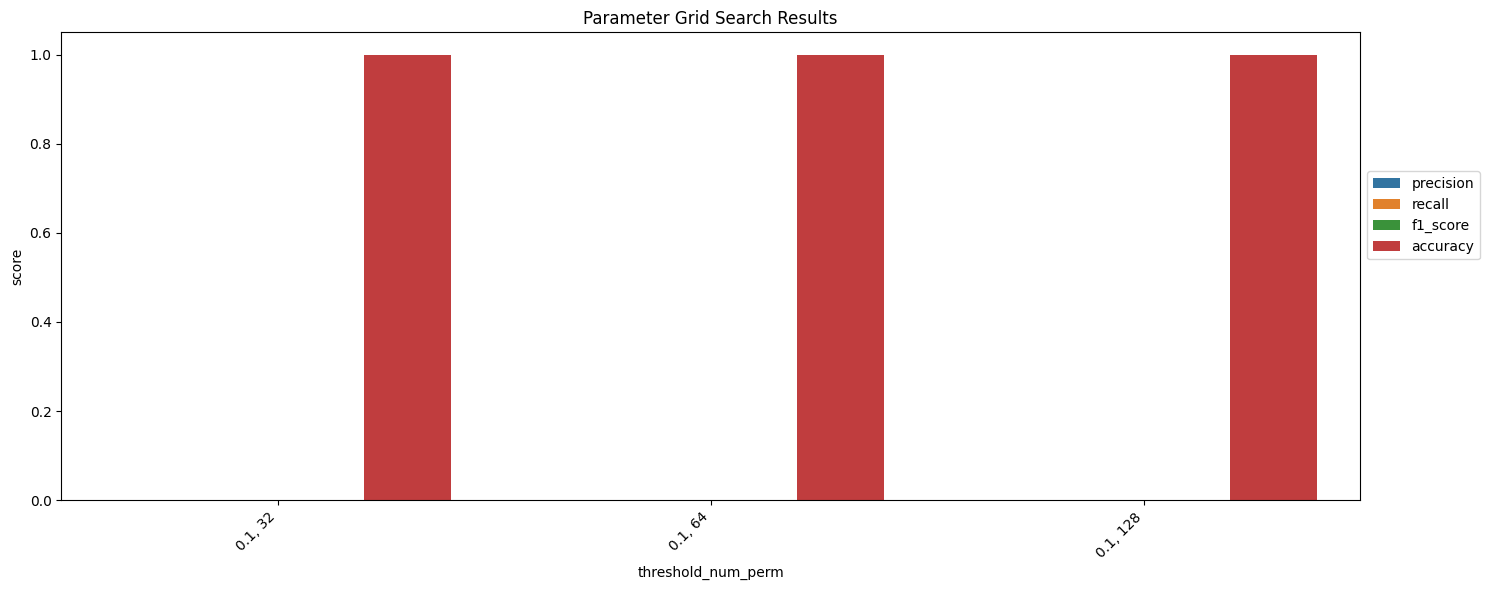

In [ ]:

# Melt the DataFrame to combine 'threshold' and 'num_perm' into a single column
melted_df = pd.melt(results_df, id_vars=['threshold', 'num_perm'],
                    value_vars=['precision', 'recall', 'f1_score', 'accuracy'],
                    var_name='metric', value_name='score')

# Create a new column combining 'threshold' and 'num_perm'
melted_df['threshold_num_perm'] = melted_df['threshold'].astype(str) + ', ' + melted_df['num_perm'].astype(str)

# Create the grouped bar plot using seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x='threshold_num_perm', y='score', hue='metric',
            data=melted_df, errorbar=None)
plt.title('Parameter Grid Search Results')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##4.6 Jaccard Similarity vs LSH Probabillity visualization

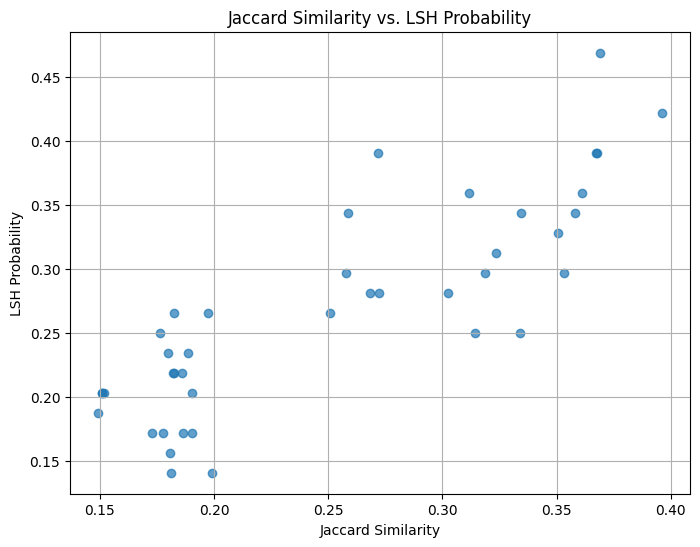

In [ ]:
#initialize minhashses
num_perm = 64
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=num_perm)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

# Initialize LSH
threshold = 0.2
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

#get candidate pairs by quering the keys for similar users
candidate_pairs = []
for user in user_songs_dict.keys():
    for other_user in lsh.query(minhashes[user]):
        if user != other_user and (other_user, user) not in candidate_pairs:  # Avoid duplicates
            candidate_pairs.append((user, other_user))

#calculate jaccard similarity and lsh probs f every pair
jaccard_similarities = []
lsh_probabilities = []

for user1, user2 in candidate_pairs:
    set1 = user_songs_dict[user1]
    set2 = user_songs_dict[user2]

    # Jaccard similarity
    jaccard = calculate_jaccard_similarity(set1, set2)
    jaccard_similarities.append(jaccard)

    # LSH probability (approximated as MinHash similarity)
    mh1 = minhashes[user1]
    mh2 = minhashes[user2]
    lsh_prob = mh1.jaccard(mh2)
    lsh_probabilities.append(lsh_prob)

# Plot Jaccard similarity vs. LSH probability
plt.figure(figsize=(8, 6))
plt.scatter(jaccard_similarities, lsh_probabilities, alpha=0.7)

plt.xlabel("Jaccard Similarity")
plt.ylabel("LSH Probability")
plt.title("Jaccard Similarity vs. LSH Probability")

plt.grid(True)
plt.show()

#5.Define Strategies for recommendations

##1 rst Approach: Items not been seen by any memebr of the group

1. Identify items not listened to by any group member.

2. Use the SVD predictions to rank these items.

3. Select the top-N items based on the predicted ratings.

In [108]:
def get_unseen_items(group, user_item_matrix):
  group_items=user_item_matrix.loc[group].sum(axis=0) #selecting rows that corresponding to group members
                                                      #and sum along the columns(vertically , down the rows)
  unseen_items=group_items[group_items==0].index.tolist()
  return unseen_items

In [109]:
print(get_unseen_items(groups[0], user_item_matrix))

[1393, 1394, 1395, 1396, 1397, 1398, 1399, 1401, 1402, 1404, 1405, 1406, 1408, 1410, 1411, 1412, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1432, 1433, 1434, 1435, 1437, 1438, 1441, 1442, 1443, 1444, 1445, 1446, 1448, 1449, 1450, 1451, 1452, 1453, 1455, 1456, 1457, 1458, 1459, 1462, 1464, 1468, 1469, 1470, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1481, 1482, 1484, 1485, 1486, 1487, 1488, 1491, 1492, 1493, 1495, 1496, 1497, 1498, 1500, 1501, 1502, 1504, 1505, 1506, 1508, 1510, 1511, 1512, 1513, 1514, 1515, 1517, 1518, 1519, 1520, 1521, 1524, 1525, 1526, 1527, 1530, 1532, 1534, 1535, 1537, 1538, 1539, 1540, 1541, 1544, 1545, 1546, 1548, 1550, 1551, 1552, 1553, 1554, 1556, 1557, 1558, 1559, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1570, 1572, 1573, 1574, 1575, 1577, 1578, 1580, 1582, 1583, 1584, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1602, 1603, 1604, 1605, 1607, 1608, 1611, 1612, 1613, 1614, 1616, 1617, 1618, 1619, 1620, 162

In [110]:
def recommend_unseen_items(group, user_item_matrix, svd_model, top_n=10):

  unseen_items=get_unseen_items(group, user_item_matrix)
  #print(unseen_items )
  predictions=[]
  for item in unseen_items:

    #predict the rating for each user of the group
    predicted_ratings=[svd_model.predict(user, item).est for user in group]

    #take the average predictions
    average_rating=sum(predicted_ratings)/len(predicted_ratings)

    predictions.append((item,average_rating))

  #sort predictions by average predicted rating
  predictions.sort(key=lambda x: x[1], reverse=True)

  #return the top n items
  top_items=[item for item, average_rating in predictions[:top_n]]
  return top_items

In [111]:
top_items=recommend_unseen_items(groups[0], user_item_matrix, best_svd)
print(top_items)

[2722, 1492, 3258, 2001, 2770, 2778, 3191, 2751, 3256, 3269]


##2nd approach:Items seen by at least one or two users in the group

In [112]:
def get_seen_items(group, user_item_matrix, min_seen=int):
  group_items=user_item_matrix.loc[group].sum(axis=0) #selecting rows that corresponding to group members
                                                      #and sum along the columns(vertically , down the rows)
  seen_items=group_items[group_items>=min_seen].index.tolist() #keep items that have seen at least by one
  return seen_items

In [130]:
def recommend_seen_items(group, user_item_matrix, svd_model, top_n=10):

  items_1=get_seen_items(group, user_item_matrix, min_seen=1)
  items_2=get_seen_items(group, user_item_matrix, min_seen=2)

  print(f"Items seen by at least one user: {len(items_1)}")
  print(f"Items seen by at least two users: {len(items_2)}")

  #calculate predicted rating sand then mean in order to get more group-oriented recommendations
  all_predictions = [svd_model.predict(user, item).est
                    for user in group for item in user_item_matrix.columns]
  group_baseline = np.mean(all_predictions)

  predictions_1=[]
  predictions_2=[]

  for item in items_1:
    predicted_ratings_1=[]
    for user in group:
      #predict the rating for each user of the group
      if user_item_matrix.loc[user,item]> 0:
        ratings=user_item_matrix_random.loc[user,item]
      else:
        ratings=svd_model.predict(user, item).est + group_baseline
      predicted_ratings_1.append(ratings)
    weighted_average_rating_1=sum(predicted_ratings_1)/len(predicted_ratings_1)
    predictions_1.append((item, weighted_average_rating_1))

  #sort predictions by average predicted rating
  predictions_1.sort(key=lambda x: x[1], reverse=True)

  #return the top n items
  top_items_1=[item for item, _ in predictions_1[:top_n]]

  for item in items_2:
    predicted_ratings_2 = []
    for user in group:
        if user_item_matrix.loc[user, item] > 0:
            ratings = user_item_matrix_random.loc[user, item]
        else:
            ratings = svd_model.predict(user, item).est + (group_baseline * 2)
        predicted_ratings_2.append(ratings)

    weighted_average_rating_2 = sum(predicted_ratings_2) / len(predicted_ratings_2)
    predictions_2.append((item, weighted_average_rating_2))

  predictions_2.sort(key=lambda x: x[1], reverse=True)
  top_items_2 = [item for item, _ in predictions_2[:top_n]]


  return top_items_1, top_items_2

In [131]:
top_items_1, top_items_2=recommend_seen_items(groups[0], user_item_matrix, best_svd)
print(top_items_1)
print(top_items_2)

Items seen by at least one user: 2237
Items seen by at least two users: 1000
[104, 474, 1044, 239, 413, 428, 542, 857, 1077, 216]
[104, 474, 1044, 346, 239, 413, 428, 542, 857, 1077]


In [126]:
top_items_2=recommend_seen_items(groups[0], user_item_matrix, best_svd)
print(top_items_2)

Items seen by at least one user: 2237
Items seen by at least two users: 1000
[104, 474, 1044, 346, 239, 413, 428, 542, 857, 1077]


In [116]:
def recommend_seen_items(group, user_item_matrix, svd_model, top_n=10):
    items_1 = get_seen_items(group, user_item_matrix, min_seen=1)
    items_2 = get_seen_items(group, user_item_matrix, min_seen=2)

    print(f"Items seen by at least one user: {len(items_1)}")
    print(f"Items seen by at least two users: {len(items_2)}")

    predictions_1 = []
    predictions_2 = []

    # Calculate group baseline prediction:
    #   (1) Average predictions for all items across group members
    #   (2) Use this as a baseline to adjust unseen item predictions

    all_predictions = [svd_model.predict(user, item).est
                       for user in group for item in user_item_matrix.columns]
    group_baseline = np.mean(all_predictions)

    #For items seen by at least one user in the group
    for item in items_1:
        predicted_ratings_1 = []
        for user in group:
            if user_item_matrix.loc[user, item] > 0:
                ratings = user_item_matrix_random.loc[user, item]  # Or keep as is
            else:
                ratings = svd_model.predict(user, item).est + group_baseline  # Adjust baseline
            predicted_ratings_1.append(ratings)

        weighted_average_rating_1 = sum(predicted_ratings_1) / len(predicted_ratings_1)
        predictions_1.append((item, weighted_average_rating_1))

    predictions_1.sort(key=lambda x: x[1], reverse=True)
    top_items_1 = [item for item, _ in predictions_1[:top_n]]

    #For items seen by at least two user in the group
    for item in items_2:
        predicted_ratings_2 = []
        for user in group:
            if user_item_matrix.loc[user, item] > 0:
                ratings = user_item_matrix_random.loc[user, item]  # Or keep as is
            else:
                ratings = svd_model.predict(user, item).est + (group_baseline * 2) # More adjustment
            predicted_ratings_2.append(ratings)

        weighted_average_rating_2 = sum(predicted_ratings_2) / len(predicted_ratings_2)
        predictions_2.append((item, weighted_average_rating_2))

    predictions_2.sort(key=lambda x: x[1], reverse=True)
    top_items_2 = [item for item, _ in predictions_2[:top_n]]

    return top_items_1, top_items_2

In [117]:
top_items_1, top_items_2=recommend_seen_items(groups[10], user_item_matrix, best_svd)
print(top_items_1)
print(top_items_2)

Items seen by at least one user: 1512
Items seen by at least two users: 573
[126, 131, 838, 1042, 66, 401, 498, 611, 889, 1637]
[126, 131, 838, 1042, 1055, 2608, 66, 401, 498, 611]


In [118]:
def check_svd_predictions(group, user_item_matrix, svd_model):
    """
    Check if SVD model returns the same predictions for min_seen=1 and min_seen=2.
    """
    items_1 = get_seen_items(group, user_item_matrix, min_seen=1)
    items_2 = get_seen_items(group, user_item_matrix, min_seen=2)

    # Take a small sample for checking
    sample_items = list(set(items_1[:6] + items_2[:6]))  # Take first 5 from each (unique items)

    print("Sample items being tested:", sample_items)

    # Store predictions
    predictions = {}

    for item in sample_items:
        pred_ratings_1 = [svd_model.predict(user,item).est for user in group]
        pred_ratings_2 = [svd_model.predict(user,item).est for user in group]

        avg_pred_1 = sum(pred_ratings_1) / len(pred_ratings_1)
        avg_pred_2 = sum(pred_ratings_2) / len(pred_ratings_2)

        predictions[item] = (avg_pred_1, avg_pred_2)

    # Print results for comparison
    print("\n **SVD Model Predictions Comparison**")
    for item, (pred1, pred2) in predictions.items():
        print(f"Item {item}: min_seen=1 -> {pred1:.4f}, min_seen=2 -> {pred2:.4f}")

    # Check if the predictions are identical
    identical_predictions = all(abs(pred1 - pred2) < 1e-5 for pred1, pred2 in predictions.values())

    if identical_predictions:
        print("\n SVD model is returning identical predictions for min_seen=1 and min_seen=2!")
    else:
        print("\n SVD model is returning different predictions for min_seen=1 and min_seen=2.")

# Run the check
check_svd_predictions(groups[0], user_item_matrix, best_svd)


Sample items being tested: [0, 1, 2, 3, 4, 5, 6, 8, 9]

 **SVD Model Predictions Comparison**
Item 0: min_seen=1 -> 3.3929, min_seen=2 -> 3.3929
Item 1: min_seen=1 -> 1.2464, min_seen=2 -> 1.2464
Item 2: min_seen=1 -> 2.2445, min_seen=2 -> 2.2445
Item 3: min_seen=1 -> 2.0715, min_seen=2 -> 2.0715
Item 4: min_seen=1 -> 2.0082, min_seen=2 -> 2.0082
Item 5: min_seen=1 -> 1.2517, min_seen=2 -> 1.2517
Item 6: min_seen=1 -> 2.3120, min_seen=2 -> 2.3120
Item 8: min_seen=1 -> 1.2762, min_seen=2 -> 1.2762
Item 9: min_seen=1 -> 2.3219, min_seen=2 -> 2.3219

 SVD model is returning identical predictions for min_seen=1 and min_seen=2!


In [119]:
predictions = [best_svd.predict(user, item).est for user in groups[0] for item in user_item_matrix.columns]
print(f" Prediction Variance: {np.var(predictions):.6f}")


 Prediction Variance: 0.606666


#6.Make model and train

##6.1 Compute user_weights based on the songs that have heard

In [ ]:
#user_weights_count = df.groupby('username')['track_id'].count()
#user_weights_mean = df.groupby('username')['rating'].mean()
#user_weights_diversity = df.groupby('username')['track_genre'].nunique()

#user_weights = (
 #   0.4 * (user_weights_count / user_weights_count.max()) +
 #   0.4 * (user_weights_mean / user_weights_mean.max()) +
 #   0.2 * (user_weights_diversity / user_weights_diversity.max())
#)


In [ ]:
user_weights=combined_df.groupby('username')['track_id'].count()

#scale them to (0,1)
user_weights=user_weights/user_weights.max()
user_weights


username
0.0     0.871089
1.0     0.604506
2.0     1.000000
3.0     0.068836
4.0     0.031289
5.0     0.538798
6.0     0.760325
7.0     0.031289
8.0     0.508761
9.0     0.046308
10.0    0.299750
Name: track_id, dtype: float64

##6.2 Train an SVD model for every user


In [ ]:
reader=Reader(rating_scale=(1, 5))
#for every group
group_suggestions=[]#list for the suggestions of the group
for group in groups:
  group_recommendations={} #dictionary to store predictions for every user with weights
                           #in the group

  #for each user train and fit and svd algorithm
  for user in group:

    #filter train data for every user
    user_data=combined_df[combined_df['username']==user]


    #Create a DataFrame for Surprise package in the form [username, track_id, rating]
    user_surprise_data=user_data[['username', 'track_id', 'rating']]

    #fit
    data=Dataset.load_from_df(user_surprise_data, reader)
    trainset = data.build_full_trainset()
    svd = SVD()
    svd.fit(trainset)

    #predict
    predictions_train=svd.test(trainset.build_testset())
    #print(f"Group:", group)
    #print(predictions_train)

    #evaluate the prediction
    #accuracy.mse(predictions_train)

    #unseen tracks of the user
    unseen_tracks =combined_df[~combined_df['track_id'].isin(user_data['track_id'])]['track_id'].unique()
    #print(unseen_tracks)

    for track in unseen_tracks:
      #predict if match
      prediction = svd.predict(user, track)
      if track not in group_recommendations:
        group_recommendations[track]=[] #if the song does not included in the list, make a list for that
      group_recommendations[track].append((prediction.est,user_weights[user])) #append in the list the estimation and its weights


  #[(2.3476610548908505, 0.02952565343659245),
  #(2.7481380706904295, 0.5024201355275896),
  #(2.393017557153354, 0.036786060019361085)])
  #compute the weighted average for unseen items
  final_recommendations={}
  for track,predictions in group_recommendations.items():
    print(f"Group Recommendations for Track {track}: {predictions}")

    total_weight=0
    weighted_sum=0
    for prediction,weight in predictions:
      #print(f"Prediction: {prediction}, Weight: {weight}")
      weighted_sum+=prediction*weight
      #print(f"Track: {track}, Weighted Sum: {weighted_sum}")

      total_weight+=weight
    final_recommendations[track]=weighted_sum/total_weight
    #print(f"Weighted Sum: {weighted_sum}, Total Weight: {total_weight}, Weighted Mean: {final_recommendations[track]}")
  #append in group_recommendations
  group_suggestions.append(sorted(final_recommendations.items(), key=lambda x: x[1], reverse=True)[:10])







KeyError: "['rating'] not in index"

In [ ]:
(group_recommendations)

In [ ]:
#print the top-10 suggestions for evefry group
for i, recommendations in enumerate(group_suggestions):
  print(f"Group {i},{recommendations}")

###6.2.1 Train an svd model for every group

In [ ]:
#train an svd for every group
#training data foer every group

reader=Reader(rating_scale=(1, 5))
group_recommendations_new=[]

for group in groups:
  group_data=df[df['username'].isin(group)]


  data=Dataset.load_from_df(group_data[['username', 'track_id', 'rating']], reader)
  trainset = data.build_full_trainset()

  #train an svd
  svd = SVD()
  svd.fit(trainset)

  #prediction for training set
  predictions_train=svd.test(trainset.build_testset())

  track_predictions=defaultdict(list)

  #for every user in the group
  for user in group:

    #user_data
    user_data=group_data[group_data['username']==user]
    #unseen tracks of the user
    unseen_tracks =df[~df['track_id'].isin(group_data[group_data['username']==user]['track_id'])]['track_id'].unique()

    for track in unseen_tracks:
      #predict if match
      prediction = svd.predict(user, track)
      if track not in track_predictions:
        track_predictions[track]=[] #if the song does not included in the list, make a list for that
      track_predictions[track].append((prediction.est,user_weights[user])) #append in the list the estimation

  #compute the weighted average for unseen items
  final_recommendations={}
  for track,predictions in track_predictions.items():
    total_weight=0
    weighted_sum=0
    for prediction,weight in predictions:
      weighted_sum+=prediction*weight
      total_weight+=weight
    final_recommendations[track]=weighted_sum/total_weight

  #append in group_recommendations
  group_recommendations_new.append(sorted(final_recommendations.items(), key=lambda x: x[1], reverse=True)[:10])




In [ ]:
#print the top-10 suggestions for evefry group
for i, recommendations in enumerate(group_recommendations_new):
  print(f"Group {i},{recommendations}")

#7.Evaluation on the recoomendations

##7.1 Evaluation /Coverage

In [ ]:
def coverage(group_suggestions,group_data,threshold):
  coverage_scores=[]

  for i,recommendations in enumerate(group_suggestions):
   # print(i)
    group=groups[i]

    coverage_leiked_by_all=0
    coverage_leiked_by_most=0
    total_recommendations=len(recommendations)

    for track, _ in recommendations:
      #see how many users have rated the song  >= threshold
      likes=sum(1 for user in group if svd.predict(user,track).est>=threshold)

      if likes==len(group):
        coverage_leiked_by_all+=1

      if likes>=(len(group)//2): #if hald of users in the group liked the song
        coverage_leiked_by_most+=1


    coverage_scores.append((coverage_leiked_by_all/total_recommendations,
                            coverage_leiked_by_most/total_recommendations))

  return coverage_scores


In [ ]:
group_data=[]
for group in groups:
  group_data.append(df[df['username'].isin(groups[0])])
#group_data[0].head()

In [ ]:
coverage_scores=coverage(group_recommendations_new,group_data,3.0)


In [ ]:
for i,group in enumerate (groups):
  print(f"Group {i}:")
  print(f"Coverage liked by all: {coverage_scores[groups.index(group)][0]}")
  print(f"Coverage liked by most: {coverage_scores[groups.index(group)][1]}")

##7.2 Evaluation/Diversity

In [ ]:
#measure evaluation across diveristy
def diversity(group_suggestions, df):
  diversity_scores=[]

  for group_recs in group_suggestions:
    track_ids = [id for id,_ in group_recs]

    #Handle where there are no track_ids
    if not track_ids:
      diversity_scores.append(0)
      continue

    #create a matrix where rows are songs ids and columns are features
    song_features_df=df.loc[df['track_id'].isin(track_ids), ['track_id', 'artists', 'album_name']].drop_duplicates()


    diversity_score = 0
    #Comparison between genres

    for i in range(len(track_ids) - 1):
      for j in range(i + 1, len(track_ids)):
        #compare pairwise genres
        song1_features = song_features_df[song_features_df['track_id'] == track_ids[i]]['album_name'].values
        song2_features = song_features_df[song_features_df['track_id'] == track_ids[j]]['album_name'].values

        #if the 2 songs are valid and different
        if song1_features.size > 0 and song2_features.size > 0 and song1_features[0] != song2_features[0]:
          diversity_score += 1

          #final diveristy score is computed as the number of diverse pairs
          #devided by the total number of possible pairs of tracks (n(n-1)/2)
          #if there is only one track the diversity is max,1

    diversity_scores.append(diversity_score / (len(track_ids) * (len(track_ids) - 1) / 2) if len(track_ids) > 1 else 1)
  return diversity_scores


In [ ]:
diversity_scores=diversity(group_recommendations_new,df)

In [ ]:
# Print diversity scores for each group
for i, diversity_score in enumerate(diversity_scores):
  print(f"Group {i + 1}: Diversity Score = {diversity_score:.4f}")


##7.3 Evaluation/Consensus

Αξιολογεί σε ποιο βαθμό τα μέλη της ομάδας έχουν καταλήξει σε συμφωνία σε σχέση με τις προτεινόμενες προτάσεις.

In [ ]:
def consensus(group_recommendations, tracks,max_rating=5):

  track_consensus_scores={}

  for track, l in group_recommendations.items():

    #extract only the rating from the group recommendations
    #ignoring the weights
    predicted_ratings=[pred for pred, _ in l]

    #calclulate the pairwise absolute differences in predicted ratings
    pairwise_diffs=[]
    #print(f"predicted_ratings {predicted_ratings}")
    #print(f"len of predicted_ratings {len(predicted_ratings)}")
    if len(predicted_ratings)<2:
      continue
    for i in range(len(predicted_ratings)-1):
      for j in range(i+1,len(predicted_ratings)):
        #print(pairwise_diffs)
        diff=abs(predicted_ratings[i]-predicted_ratings[j])
        #print(f"diff {diff}")
        pairwise_diffs.append(diff)

    #average pairwise differenses
    avg_pairwise_diff=sum(pairwise_diffs)/len(pairwise_diffs)

    #calculate consensus score
    consensus_score=1-avg_pairwise_diff/(max_rating * (len(group)-1)/2)

    track_consensus_scores[track]=consensus_score

  return track_consensus_scores

In [ ]:
#group_suggestions is a list where each element corresponds to a list of recommended tracks for a group
for i, (group, suggestions) in enumerate(zip(groups, group_recommendations_new)):
    # Print group information
    print(f"Group {i + 1} (Users: {group}):")

    # Get only the track IDs from suggestions to pass into the consensus function
    tracks_in_suggestions = [track for track, _ in suggestions]

    # Calculate the consensus scores only for the tracks in suggestions
    group_consensus_scores = consensus(track_predictions, tracks_in_suggestions)

    # Print consensus score for each track in this group's suggestions
    for track, _ in suggestions:

        print(f"Track {track}: Consensus Score = {group_consensus_scores.get(track,'none')}")


##7.4 Evaluation/Fairness

In [ ]:
def fairness(group_suggestions, df, threshold=3.0):
  fairness_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    satisfied_users=0

    for user in group:

      #measure how many users in the group have rated the suggested song above threshold
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]

      ratings_count=user_ratings[user_ratings['rating']>threshold].shape[0]

      #if the user is satisfied from one song or more
      if ratings_count>0 :
        satisfied_users+=1

    fairness_scores.append(satisfied_users/len(group))

  return fairness_scores





In [ ]:
#dispaly fairness_score for each group
fairness_scores=fairness(group_recommendations_new,df)
for i, fairness_score in enumerate(fairness_scores):
  print(f"Group {i + 1}: Fairness Score = {fairness_score:.4f}")

###M-prop fairness

In [ ]:
def m_prop(m_items, suggestions, df, threshold=3.0):
  m_prop_scores = []
  for group_idx , suggestions in enumerate(group_recommendations_new):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    gp = 0
    g = len(group)
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0] #shape[0] holds the number of lins of the df
                                                                                #that the user has rated songs > th

      if ratings_count >= m_items:
        gp += 1

    m_prop_scores.append(gp / g)

  return m_prop_scores

In [ ]:
m_prop_scores=m_prop(2, group_recommendations_new,df)
for i, m_prop_score in enumerate(m_prop_scores):
  print(f"Group {i + 1}: M-Prop Score = {m_prop_score:.4f}")

###M-envy fairness

In [ ]:
#calculate the top  x% suggestions per group

def top_x_percent_suggestions(group_suggestions, percentage):

  top_suggestions_per_group = set()
  for group_rec in group_suggestions:
      # Sort the suggestions in descending order based on the predicted rating.
      sorted_recs = sorted(group_rec, key=lambda x: x[1], reverse=True)

      # Calculate the number of suggestions to keep.
      num_to_keep = int(len(sorted_recs) * (percentage / 100))

      # Handle cases where num_to_keep is 0.
      num_to_keep = max(1, num_to_keep)

      top_suggestions_per_group.update([track_id for track_id , _ in sorted_recs[:num_to_keep]])
  return top_suggestions_per_group



In [ ]:
tops={}
for i, (group, suggestions) in enumerate(zip(groups, group_recommendations_new)):
    # Print group information
    tops[i]=top_x_percent_suggestions([suggestions], 25) #wrap suggestions into a list to match the input type

In [ ]:
tops

In [ ]:
def m_envy_fairness(group_suggestions, df, top_x_percent=0.25, m_items=3, threshold=3.0):

  top_group_suggestions=top_x_percent_suggestions(group_suggestions, top_x_percent)
  m_envy_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = tops[group_idx]

    envy_count=0
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0]

      if ratings_count >= m_items:
        envy_count += 1

    envy_count=envy_count/len(group)
    m_envy_scores.append(envy_count / len(group))

  return m_envy_scores





In [ ]:
#count the envy scores for every group and print
m_envy_scores=m_envy_fairness(group_recommendations_new,df)
for i, m_envy_score in enumerate(m_envy_scores):
  print(f"Group {i + 1}: M-Envy Score = {m_envy_score:.4f}")

#8.Paper icdm-2016 GR-INC UP-INC

##GR-INC

Ο GR-INC αλγόριθμος συνδυάζει τις φάσεις I2G και P2G επαναληπτικά.

Στην φάση **I2G** υπολογίζεται η πιθανότητα κάθε αντικειμένου να επιλεγεί από το group βασιζόμενος στις ατομικές προτάσεις του κάθε χρήστη. Χρησιμοποείται η εξίσωση (2) ,δηλαδή η πιθανότητα ενός αντικιεμένου να επιλεχθέι είναι ένα σταθμισμένο άθροισμα όλων των πιθανοτήτων κάθε χρήστη του group με βάρος την εμπειρία κάθε χρήστη στην κατηγορία που ανήκει το αντικείμενο που εξετάζεται.

Στην φάση **P2G** συνδυάζονται τα αντικείμενα που επιλέχθηκαν σε πακέτα.Λαμβάνει υπόψη του 3 παράγοντες.



1.   Τις προτιμήσεις των χρηστών
2.   Δικαιοσύνη μεταξύ των μελών
3.   Βιωσιμότητα του πακέτου ( Pr(I, V | U, C) )


Τέλος διατηρεί τα κορυφάια k πακέτα στην λίστα αποτελεσμάτων



In [ ]:
# def calculate_item_to_group_probabillities(group, user_ratings):
#   i2g_prob=defaultdict(list) #track id as a key rating value as a value
#   group_probabillities={}
#   for user in group:

#     #Compute P(i|u) for every user
#     user_data=df[df['username']==user]
#     total_rating=user_data['rating'].sum()

#     for _,row in user_data.iterrows():
#       track_id=row['track_id']
#       rating=row['rating']

#       #assuming equal activity for simplicity
#       prob_i_given_u=(1/3)*rating
#       i2g_prob[track_id].append(prob_i_given_u)
#       #print(track_id,rating)

#   #calculate total propabillity for the group P(i|u) as the average of the probs
#   #of the users in the group
#   for track_id,probs in i2g_prob.items():
#     group_probabillities[track_id]=sum(probs)/len(probs)


#   return group_probabillities







In [ ]:
# def gr_inc_recommendations(group, user_ratings, top_k):
#
#   i2g_prob=calculate_item_to_group_probabillities(group, user_ratings)

#   #ranking
#   ranked_items=sorted(i2g_prob.items(),key=lambda x:x[1],reverse=True)
#   #print(ranked_items)

#   #recommend the top_k
#   top_k_items=ranked_items[:top_k]

#   return top_k_items

In [ ]:
# group=groups[0]
# recommendations=gr_inc_recommendations(group,df, top_k=8)
# print(f"recommendations for group 0:{recommendations}")



In [ ]:
def group_items_by_genre(df):

  #group the songs based on genre
  items_by_category=df.groupby('track_genre')['track_id'].apply(list).to_dict()
  return items_by_category


In [ ]:
items=print(group_items_by_genre(df))

In [ ]:
#Compute P(i|U,ci) for each item
def compute_item_to_group_probability(group, items, user_ratings):
  probabillities={}
  for item in items:

    #assuming equal probs for every user
    prob=sum(user_ratings[(user_ratings['username']==user)
                        & (user_ratings['track_id']==item)]['rating'].sum() *1/3
             for user in group)

    #print(prob)
    probabillities[item]=prob
    #print(probabillities)

  #normalize the probabilities
  total_prob=sum(probabillities.values())
  for item in probabillities:
    probabillities[item]/=total_prob
  return probabillities

In [ ]:
# Incremental I2G
def gr_inc_i2g(group, items_by_category, user_ratings, k):
    """
    Υπολογίζει τα top-k τραγούδια για κάθε κατηγορία σε μια ομάδα.
    """
    category_probabilities = {}
    for category, items in items_by_category.items():
        #print(category, items) #alt-rock [2594.0, 2207.0]
        probabilities = compute_item_to_group_probability(group, items, user_ratings)
        #print(f"probabilieties for category {category}={probabilities}")

        #sorted probabilieties in descending order
        sorted_probs= sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        category_probabilities[category] = sorted_probs[:k]
    return category_probabilities



In [ ]:
from itertools import product

#GR-INC implementation
def gr_inc(group, user_ratings, k):

    #group tracks by genre
    items_by_category = group_items_by_genre(user_ratings)
    categories = list(items_by_category.keys())

    # I2G Phase: compute top-k packages from every category to  make the packages
    category_top_items = gr_inc_i2g(group, items_by_category, user_ratings, k)

    # P2G Phase: Making packages
    packages = []
    for package in product(*(category_top_items[cat] for cat in categories)):
      #use cartesian product
      #to do all the possible combinations  from top items per caegory
        #print(category_top_items[cat] for cat in categories)()
        package_items = [item for item, _ in package] #extract item ignoring the score
        package_score = sum(score for _, score in package) #extract score ignoring the item
        packages.append((package_items, package_score))

    #select only the top-k packages
    packages.sort(key=lambda x: x[1], reverse=True)
    return packages[:k]

In [ ]:
group = groups[0]
for user in group:


    user_data=df[df['username']==user]
    user_ratings=user_data[['username', 'track_id','track_genre' ,'rating']]

top_k =4
top_k_packages=gr_inc(group, user_ratings, top_k)
print("Top-k Packages for GR-INC:")
for package in top_k_packages:
    print(f"Tracks: {package[0]}, Score: {package[1]:.2f}")

##UP-INC

Βήματα αλγορίθμου

1. Επιλογή αντιπροσωπευτικού χρήστη: Ο αλγόριθμος επιλέγει έναν αντιπροσωπευτικό χρήστη για την ομάδα, οποίος θα αποφασίσει για το πακέτο. Η πιθανότητα επιλογής αυτού του χρήστη υπολογίζεται με βάση την επιρροή του σε όλες τις κατηγορίες αντικειμένων.

2. Υπολογισμός Πιθανοτήτων: Ο UP-INC υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον αντιπροσωπευτικό χρήστη, χρησιμοποιώντας τις προτιμήσεις του για τα αντικείμενα που περιλαμβάνονται στο πακέτο. Αυτό γίνεται με την εξίσωση:
Pr(I∣U,C)=∑u∈U​Pr(u∣U,C)⋅Pr(I∣u,C)
όπου Pr(I∣u,C) είναι η πιθανότητα επιλογής του πακέτου από τον χρήστη u.

3. Δύο κύριες φάσεις:

   **P2U phase:** Για κάθε χρήστη υπολογίζει τις πιθανότητες επιλογής των πακέτων

   **I2G phase:** Συνδυάζει τις πιθανότητες για να βρει τα καλύτερα πακέτα για την ομάδα

4. Αποτελεσματικότητα: Ο UP-INC είναι
   σχεδιασμένος να είναι πιο αποδοτικός από τον UP-BA, καθώς υπολογίζει τις πιθανότητες με έναν πιο στοχευμένο και σταδιακό τρόπο, μειώνοντας την υπολογιστική πολυπλοκότητα.

In [ ]:
def calculate_user_influence(user,category_items):
  #print(category_items.head(5))
  user_category_ratings=category_items[category_items['username']==user]['rating'].count()
  total_category_ratings=category_items['rating'].count()
  return user_category_ratings/total_category_ratings if total_category_ratings>0 else 0

In [ ]:
def calculate_package_probability(user, package, category_items):
  """
  Υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον χρήστη.
  """
  total_prob = 1
  for item in package:
    item_rating = category_items[(category_items['username'] == user)
                               & (category_items['track_id'] == item)]['rating'].mean()
    if not np.isnan(item_rating):
      total_prob *= item_rating
    else:
      total_prob = 0.01 #low possibility for this item , which is not rated
      #break;
  return total_prob

In [ ]:
def combine_user_package_probabilities(group, package, category_items):
    #combine user probabilities to calculate the probability of the package
    total_prob = 0
    total_influence = 0
    for user in group:
        influence = calculate_user_influence(user, category_items)
        user_prob = calculate_package_probability(user, package, category_items)
        total_prob += influence * user_prob
        total_influence += influence
    return total_prob / total_influence if total_influence > 0 else 0


**Διαφορά GR-INC με τον UP-INC**

Ο αλγόριθμος GR-INC βασίζεται σε ένα μοντέλο που επιλέγει αντικέιμνα ανεξάρτητα, εστιάζοντας στις προτιμήσεις ενός αντιπροσωπευτικού χρήστη. Ο χρήστης αυτός επιλέγεται με βάση την εμπειρία του και την επιρροή του στην κατηγορία των αντικειμένων. Αντίθετα ο UP-INC επιλέγει πρώτα έναν αντιπροσωπευτικό χρήστη για την ομάδα και στην συνέχεια αυτός ο χρήστης αποφασίζει για ολόκληρο το πακέτο. Η επιλογή των αντικειμένων γίνεται με βάση τις προτιμήσεις αυτού του χρήστη και η επιρροή του υπολογίζεται σε σχέση με όλες τις κατηγορίες αντικειμένων.  


In [ ]:
def up_inc(group, user_ratings, k):
    #group items by category
    items_by_category=group_items_by_genre(user_ratings)
    categories=list(items_by_category.keys())

    package_probabilities=[]

  # P2U Phase: Υπολογισμός πιθανότητας πακέτων για κάθε χρήστη
    for user in group:
        user_probabilities = []
        for category, items in items_by_category.items():
            for item in items:
                prob = calculate_package_probability(user, [item], user_ratings)
                heapq.heappush(user_probabilities, (-prob, item))



        #select k top items for the user
        user_top_items=[heapq.heappop(user_probabilities)[1] for _ in range(min(k, len(user_probabilities)))]
        package_probabilities.append((user,user_top_items))
    print(f"User {user} top items: {user_top_items}")
    #P2G phase:Combine packages for th group
    final_packages=[]
    seen_packages=set()
    for package_comb in product(*(user_top for _, user_top in package_probabilities)):
      package_items=tuple(sorted(set(item for item in package_comb))) #sorted unique items
      if package_items in seen_packages:
       continue
      seen_packages.add(package_items)
      package_score=combine_user_package_probabilities(group, package_items, user_ratings)
      final_packages.append((package_items,package_score))
      #print(f"Package:{package}, Score:{score}")
    #print(f"Seen packages:{len(seen_packages)}")

    final_packages.sort(key=lambda x:x[1],reverse=True)
    return final_packages[:k]



In [ ]:
group = groups[0]
user_data = df[df['username'].isin(group)]
top_k = 4

top_k_packages = up_inc(group, user_data, top_k)

print("Top-k Packages for UP-INC:")
for i, (package, score) in enumerate(top_k_packages):
    print(f"Package {i + 1}: Tracks: {package}, Score: {score:.2f}")
